In [1]:
# Import Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import CSV with top zip codes
top_zips_df = pd.read_csv('../Resources/25 Final Zip Codes.csv')

In [3]:
# Create list of top 25 zips from the csv file
zip_codes = top_zips_df["zip"]

In [4]:
# Create initial lists for everything we are pulling from the data frame
listing_type = []
addresses = []
prices = []
zips = []
lats = []
lons = []
sqft = []
beds = []
baths = []

In [5]:
# Set up url to call to Realtors "sold houses" API
url = "https://realtor.p.rapidapi.com/properties/list-sold"

# Set up initial parameters
querystring = {"sort":"relevance",
               "offset":"0",
               "limit":"200"}

# Set up headers to call through Rapid API
headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': "aaf97ab322msh634818fa34ec594p1b03e3jsnaf892e7d4ed3"
    }

# Begin for loop, looking through the zip codes in the Top 25 Zip File
for zip in zip_codes:
    
    counter=-1

    # Update parameters with the current zip code
    querystring['postal_code'] = zip
    
    # Was having issues with various zips not pulling, put in exception handling to keep it moving
    try:
        response = requests.request("GET", url, headers=headers, params=querystring).json()
        sold_listings = response["listings"]
    except:
        continue
    
    # Once we've pulled the json for the current zip, we extract values from the json and add to our initial lists.
    for listing in sold_listings:
        try: 
            counter = counter+1
            address = sold_listings[counter]["address"]
            price = int(sold_listings[counter]["price_raw"])
            lat = sold_listings[counter]["lat"]
            lon = sold_listings[counter]["lon"]
            zip = int(address[-5:])
            sft = sold_listings[counter]["sqft_raw"]
            bed = sold_listings[counter]["beds"]
            bath = sold_listings[counter]["baths"]
            listing_type.append("Sold")
            addresses.append(address)
            prices.append(price)
            lats.append(lat)
            lons.append(lon)
            zips.append(zip)
            sqft.append(sft)
            beds.append(bed)
            baths.append(bath)
        except (KeyError, IndexError):
            listing_type.append(None)
            addresses.append(None)
            prices.append(None)
            lats.append(None)
            lons.append(None)
            zips.append(None)
            sqft.append(None)
            beds.append(None)
            baths.append(None)

In [6]:
# Call to houses for sale API - Same format as above!
url = "https://realtor.p.rapidapi.com/properties/list-for-sale"

querystring = {"sort":"relevance",
               "offset":"0",
               "limit":"200"}

headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': "aaf97ab322msh634818fa34ec594p1b03e3jsnaf892e7d4ed3"
    }

for zip in zip_codes:
    
    counter=-1

    # update address key value
    querystring['postal_code'] = zip
    
    try:
        response = requests.request("GET", url, headers=headers, params=querystring).json()
        for_sale_listings = response["listings"]
    except:
        continue
    
    
    for listing in for_sale_listings:
        try: 
            counter = counter+1
            address = for_sale_listings[counter]["address"]
            price = int(for_sale_listings[counter]["price_raw"])
            lat = for_sale_listings[counter]["lat"]
            lon = for_sale_listings[counter]["lon"]
            zip = int(address[-5:])
            sft = for_sale_listings[counter]["sqft_raw"]
            bed = for_sale_listings[counter]["beds"]
            bath = for_sale_listings[counter]["baths"]
            listing_type.append("For Sale")
            addresses.append(address)
            prices.append(price)
            lats.append(lat)
            lons.append(lon)
            zips.append(zip)
            sqft.append(sft)
            beds.append(bed)
            baths.append(bath)
        except (KeyError, IndexError):
            listing_type.append(None)
            addresses.append(None)
            prices.append(None)
            lats.append(None)
            lons.append(None)
            zips.append(None)
            sqft.append(None)
            beds.append(None)
            baths.append(None)

In [7]:
# Create a data frame to hold results from the 2 API pulls above, create Price per Square Foot column.
combined_df = pd.DataFrame()
combined_df["Listing Type"]= listing_type
combined_df["Address"]=addresses
combined_df["Prices"]=prices
combined_df["Lat"]=lats
combined_df["Lon"]=lons
combined_df["Zip"]=zips
combined_df["Sq Ft"]=sqft
combined_df["Beds"]=beds
combined_df["Baths"]=baths
combined_df["Price per Square Foot"]=""

In [8]:
# Reformat Sq Ft as a float, remove listing with 0 sq ft (new builds, land, etc.), calculate price per square foot.

combined_df["Sq Ft"] = combined_df["Sq Ft"].astype(float)
combined_df["Prices"] = combined_df["Prices"].astype(float)

combined_df = combined_df.loc[(combined_df["Sq Ft"]>0),:]
combined_df["Price per Square Foot"] = combined_df["Prices"]/combined_df["Sq Ft"]

combined_df.head()

,Listing Type,Address,Prices,Lat,Lon,Zip,Sq Ft,Beds,Baths,Price per Square Foot
0,Sold,10350 W 55th Ln Unit 202 in Oberon West - Arva...,350000.0,39.796539,-105.117386,80002.0,1313.0,2.0,3,266.565118
1,Sold,"5563 Newland Way, Arvada, 80002",420000.0,39.797902,-105.070391,80002.0,2092.0,4.0,4,200.764818
2,Sold,"5747 Falk Ct in Arvada Plaza Area - Arvada,CO,...",445500.0,39.800982,-105.098869,80002.0,1320.0,3.0,3,337.500000
3,Sold,"4890 Estes St in Pleasant Valley - Arvada,CO, ...",360000.0,39.785095,-105.094654,80002.0,1228.0,5.0,1,293.159609
4,Sold,"5515 Otis Ct in Vetting - Arvada,CO, Arvada, 8...",376000.0,39.796628,-105.071632,80002.0,983.0,2.0,1,382.502543


In [9]:
# Create two data frames, one for Homes Sold recently and one for Houses for Sale currently. 
# I realized there are some outliers in the Sold data (not sure whats going on but some are thousands per sq ft)
# Removing those outliers that are unrelatiscally priced. 

for_sale_df = combined_df.loc[(combined_df["Listing Type"] == "For Sale"),:]
sold_df = combined_df.loc[(combined_df["Listing Type"] == "Sold") & (combined_df["Price per Square Foot"] < 1000),:]

In [10]:
# Creating csv files so the API does not need to be called every time
for_sale_output = "../Resources/for_sale.csv"
sold_output = "../Resources/sold.csv"
for_sale_df.to_csv(for_sale_output)
sold_df.to_csv(sold_output)


In [11]:
# Calling the saved files for plots below
for_sale_df = pd.read_csv(for_sale_output)
sold_df = pd.read_csv(sold_output)

In [17]:
# Cleaning up zip code column to remove decimal
for_sale_df['Zip'] = for_sale_df['Zip'].astype(int)
sold_df['Zip'] = sold_df['Zip'].astype(int)

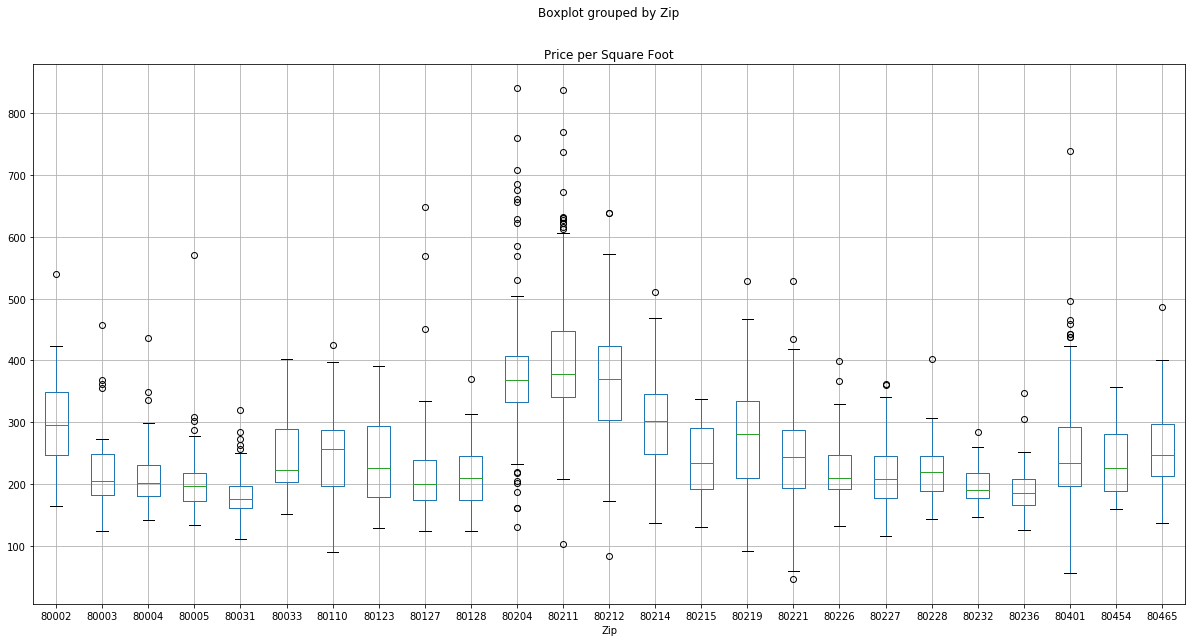

In [18]:
# Create a boxplot to compare means
for_sale_df.boxplot("Price per Square Foot", by="Zip", figsize=(20, 10))
plt.show()

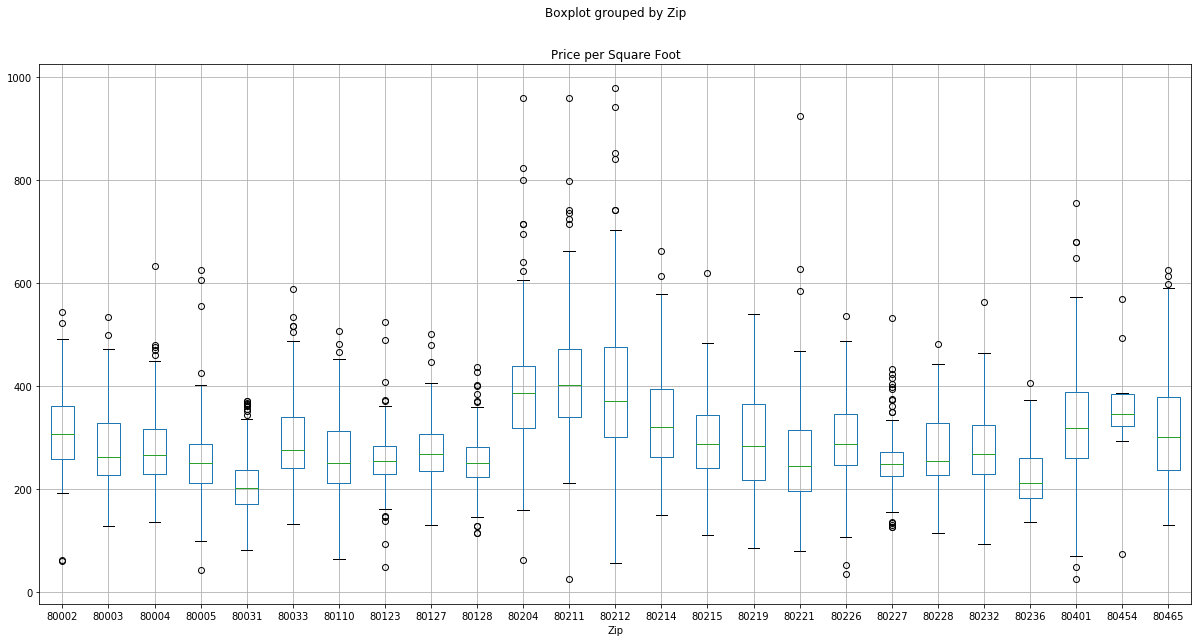

In [19]:
# Create a boxplot to compare means
sold_df.boxplot("Price per Square Foot", by="Zip", figsize=(20, 10))
plt.show()